In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [3]:
# Circuit
Rs = 0.001# Ω
RL = 2.0  # Ω
CL = 10e-12 # F

# Parameters
Δt = 0.01e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
a, b = 1.00, 0.02
n, m = 100, 2
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_CIR  = 4

function dof_type(n, m)
    global NUM_EDGES
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
        if 1 <= i_edge <= n
            dof_flag[i_edge] = DOF_PEC
        end
        
        if 1 <= (NUM_EDGES - i_edge + 1) <= n
            dof_flag[i_edge] = DOF_PEC
        end
    end
    for i_edge =  n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_SRC
        println("$i_edge => SRC")
    end
    for i_edge = 2n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_ABC
        println("$i_edge => ABC")
    end
    for i_edge =  n+1+40:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_CIR
        println("$i_edge => CIR")
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

101 => SRC
302 => SRC
201 => ABC
402 => ABC
141 => CIR
342 => CIR


In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


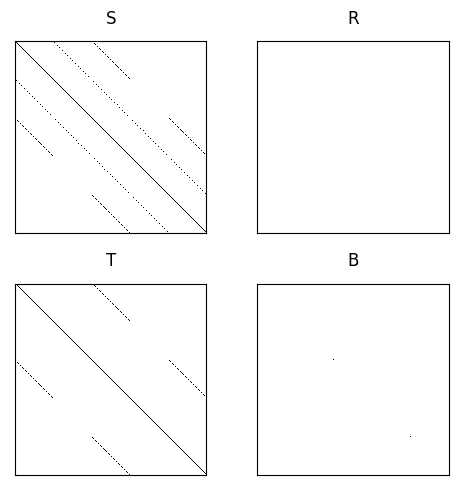

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
P = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / L
G = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / R
C = spzeros(NUM_DOFS, NUM_DOFS) # μ0 * C
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_CIR
    len = ly
    G[dof[ii], dof[ii]] += μ0 * len^2 / RL * (b / len)
    C[dof[ii], dof[ii]] += μ0 * len^2 * CL * (b / len)
  end

  if Γ[ii] == DOF_SRC
    len = ly
    G[dof[ii], dof[ii]] += μ0 * len^2 / Rs * (b / len)
  end

end
S += P
R += G
T += C
nothing

In [10]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [11]:
x = 0.010:0.050:0.510
y = 0.005:0.002:0.015
xx, yy = meshgrid(x, y);

it  = 1
nt  = 1000
t   = 0.00
e   = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vol = zeros(nt)
nothing

In [12]:
using IterativeSolvers

function current(t) 
    if 0e-9 < t < 0.5e-9 return +1.0 end
    if 2e-9 < t < 2.5e-9 return -1.0 end
    return 0.0
end

F = lu(A)
@elapsed for _ = it:nt
    bi = (-0.25Δt^2 * S -  T + 0.5Δt * B + 0.5Δt * R) * epp +
         (-0.50Δt^2 * S + 2T) * ep
         
    bbi = zeros(NUM_EDGES)
    for ii = 1:NUM_EDGES
      if Γ[ii] == DOF_SRC
            len = ly
            bbi[dof[ii]] = len^2 * current(t) / Rs
      end
    end
    
    #cg!(e, A, (bi + μ0 * Δt * bbi)) # 0.59
    #e   .= A \ (bi + μ0 * Δt * bbi) # 0.71
    e   .= F \ (bi + μ0 * Δt * bbi) # 0.48
    epp .= ep
    ep  .= e

    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vol[it] = sum(e[dof[Γ .== DOF_CIR]])

    it += 1
    t  += Δt
end

0.48706803

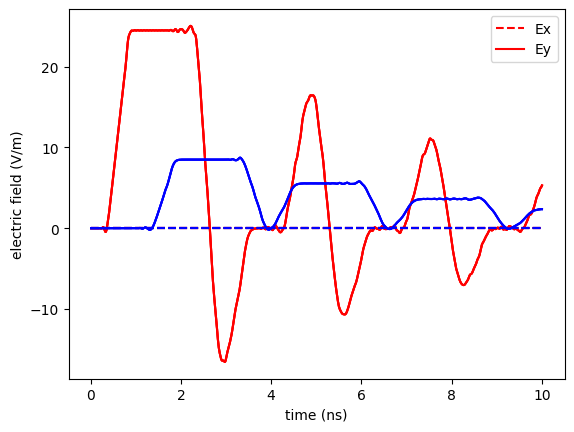

PyObject <matplotlib.legend.Legend object at 0x7fd7fdeae910>

In [13]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 1], "r--", ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 2, 1], "r--", ts, res[:, 3, 2, 2], "r-")
plot(ts, res[:, 3, 3, 1], "r--", ts, res[:, 3, 3, 2], "r-")
plot(ts, res[:, 9, 1, 1], "b--", ts, res[:, 9, 1, 2], "b-")
plot(ts, res[:, 9, 2, 1], "b--", ts, res[:, 9, 2, 2], "b-")
plot(ts, res[:, 9, 3, 1], "b--", ts, res[:, 9, 3, 2], "b-")
xlabel("time (ns)")
ylabel("electric field (V/m)")
legend(["Ex", "Ey"])

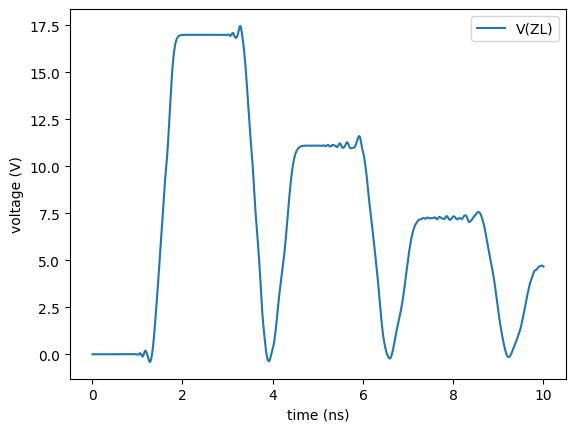

PyObject <matplotlib.legend.Legend object at 0x7fd7f6736f10>

In [14]:
ts = 1e9Δt * collect(1:nt)
grid()
plot(ts, vol)
xlabel("time (ns)")
ylabel("voltage (V)")
legend(["V(ZL)"])